# <5주차 과제>
- 지금까지 배운 DL, CNN 개념을 활용하여,
- modern CNN을 직접 구현해보자.

- 더하여, 코드 중간중간의 Question을 해결해보자. (총 6개의 질문)
- 1) AlexNet
            Q1. 바로 하단의 layer후에 size가 227->55가 되도록 kernel_size 설정
            Q2. 아래의 활성화 함수(####) 채워 넣기 (모든 layer에 대해)
            Q3. pooling 방식(함수) 채워 넣기 (모든 layer에 대해)
- 2) VGGNet
            Q4. 아래의 셀에 직접 conv block 갯수를 함수의 파라미터로 설정해서 넣을 수 있는 코드를 작성 (책의 코드 참고)
- 3) GoogleNet
            Q5. 아래의 빈칸(####)을 위에 정리된 path함수들로 채워넣기

- 4) ResNet
            Q6. 빈칸 채워넣기


In [1]:
import torch
import torchvision
from torchvision import transforms, datasets

import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# 랜덤 시드 고정
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda:0':
    torch.cuda.manual_seed_all(777)

import time
import copy

In [2]:
print(device)

cuda:0


In [3]:
from tqdm.notebook import tqdm

def training_model(model, data_loader, epochs):
  since = time.time() #시작 시간을 기록(총 소요 시간 계산을 위해)

  best_model_wts = copy.deepcopy(model.state_dict())  # 모든 epoch에서 학습 된 모델 중 best model의 가중치를 저장하는 변수
  best_acc = 0

  for epoch in range(epochs):
    avg_cost = 0

    for phase in ['train', 'val']:  # train mode와 validation mode 순으로 진행
        if phase == 'train':
            model.train()  # model을 training mode로
        else:
            model.eval()   # model을 validation mode로(드롭아웃, 배치정규화 등을 사용하지 않음)

        for X, Y in tqdm(data_loader[phase]):
            X, Y = X.to(device), Y.to(device)

            optimizer.zero_grad()   # 지난 iteration에서 계산했던 기울기 초기화

            with torch.set_grad_enabled(phase == 'train'):  # training mode에서는 gradient를 기억하여 가중치를 수정해야 함
                                                            # validation mode에서는 가중치를 수정하지 않으므로 필요 없음
                hypothesis = model(X)   # 순전파 과정으로 예측값 도출
                cost = criterion(hypothesis, Y)   # 예측값과 실제값을 비교한 loss

                if phase == 'train':
                    cost.backward()   # 역전파, 기울기 계산
                    optimizer.step()   # optimizer로 가중치 갱신
                    avg_cost += cost / total_batch[phase]

                else: # validation에서는 역전파로 가중치를 학습할 필요 없음
                    prediction = model(X)   # 학습한 모델로 test 데이터의 예측값 도출(각 숫자에 해당할 확률)
                    prediction = prediction.to(device)
                    correct_prediction = torch.argmax(prediction, 1) == Y   # 모든 확률 중에서 가장 큰 확률을 가진 숫자를 예측값으로 지정하고 이를 실제값과 비교
                    global accuracy
                    accuracy = correct_prediction.float().mean().item()   # 정확도 계산

        if phase == 'train':
            print('[Epoch: {:>4}] train cost = {:.4f}'.format(epoch + 1, avg_cost)) # training 과정에서 각 epoch 마다의 cost 출력
        else:
            print('val Accuracy = {:.4f}', accuracy)  # validation 과정에서 각 epoch에서 학습된 모델의 성능 출력
            print('='*100)

        if phase == 'val' and accuracy > best_acc:  # 이번 epoch에서 만들어진 모델이 이전에 만들어진 모델보다 더 성능이 좋을 경우, best model을 수정
            best_acc = accuracy
            best_model_wts = copy.deepcopy(model.state_dict())

  training_time = time.time() - since   # 학습 경과 시간
  print('total training time for {} epochs: {:.0f}m {:.0f}s'.format(epochs, training_time//60, training_time%60))
  print('Best val Accuracy: {:.4f}'.format(best_acc))

  model.load_state_dict(best_model_wts)
  return model  # best model 반환
    

## CIFAR-10 dataset

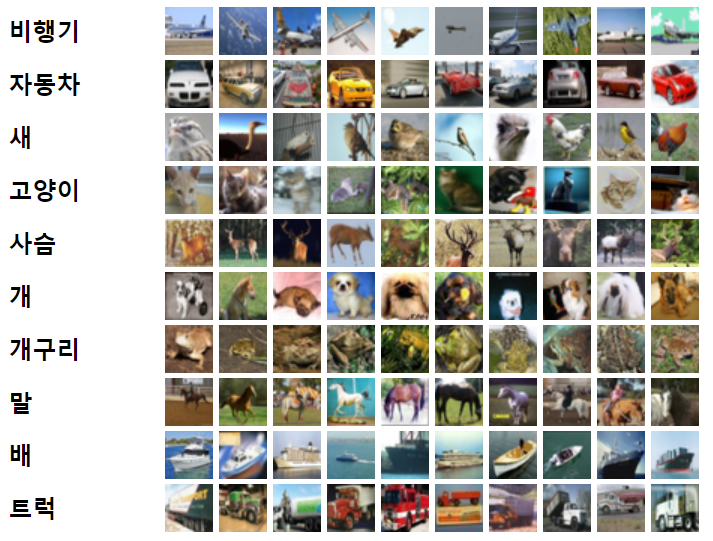

CIFAR-10 데이터셋은 10개의 클래스로 분류되는 사물 이미지로 구성된 Computer Vision의 대표적이 데이터셋이다. 한 이미지는 32*32 크기로 이루어져 있으며, 컬러 이미지이므로 3개의 채널(RGB)로 구성되어 있다. 각 클래스 당 5000개의 training 데이터와 1000개의 test 데이터를 갖고 있다. (총 training set: 50000개, 총 test set: 10000개)

torchvision 을 사용하여 CIFAR-10 데이터셋을 불러오고, 정규화(nomarlizing)할 수 있다. 자세한 내용은 https://tutorials.pytorch.kr/beginner/blitz/cifar10_tutorial.html 참고

In [24]:
# Data Augmentation
transform = transforms.Compose([
                                transforms.Resize(256),
                                transforms.RandomCrop(227), 
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  #3채널(R,G,B) 데이터의 평균과 분산을 0.5로 설정

])

In [25]:
batch_size = 64

cifar_train = datasets.CIFAR10('~/.data', download=True, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=batch_size, shuffle=True)  #batch_size는 원하는 크기로 변경 가능. 
                                                                                              #단, 2의 제곱수로 하고 test_loader의 batch_size도 동일한 수로 변경할 것.

cifar_test = datasets.CIFAR10('~/.data', download=True, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=batch_size, shuffle=True)

data_loaders = {'train' : train_loader, 'val': test_loader}
total_batch = {'train' : len(train_loader), 'val': len(test_loader)}

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


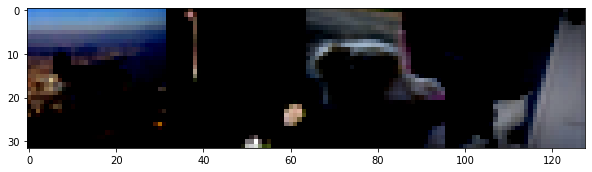

In [8]:
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np

dataiter       = iter(train_loader)   # iter함수로 iteration 객체 가져오기
images, labels = next(dataiter)   # next함수로 다음 배치 1개 갖고오기

img   = utils.make_grid(images[:4], padding=0)
npimg = img.numpy()
plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()

## 1) AlexNet 구현 및 실제 데이터 적용하기

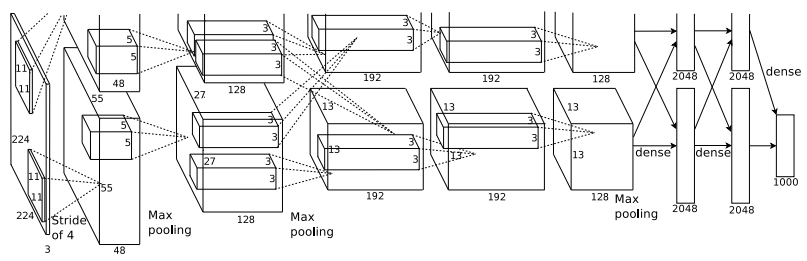

CNN 구조에서 큰 발전을 이끈 신경망이다. 

2개의 GPU에서 신경망 학습, LRN 사용, overlapping pooling 등의 기법을 통해 성능을 크게 향상시켰다.

In [10]:
class AlexNet(nn.Module):
    def __init__(self, input_size = 227, num_classes=10):  # data augmentation 과정에서 이미지 크기를 227로 crop했으므로, input_size = 227
                                                           # CIFAR-10 데이터는 총 10개의 종류로 분류되므로, num_classes = 10
        super(AlexNet, self).__init__()

        # CNN Layer
        self.CNNLayer = nn.Sequential(
            # 1st Conv layer

            # Q1. 바로 하단의 layer후에 size가 227->55가 되도록 kernel_size 설정

            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, padding = 0, stride=4),  

            # Q2. 아래의 활성화 함수(####) 채워 넣기 (모든 layer에 대해)
            # Q3. pooling 방식(함수) 채워 넣기 (모든 layer에 대해)
            
            nn.ReLU(inplace=True),  

            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),  # LRN
            nn.MaxPool2d(kernel_size=3, stride=2),  # overlap pooling, 55->27

            # 2nd Conv layer
            nn.Conv2d(96, 256, 5, padding = 2, stride = 1),  # 27->27
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 27->13

            # 3rd Conv layer
            nn.Conv2d(256, 384, 3, padding = 1, stride = 1),  # 13->13
            nn.ReLU(inplace=True),

            # 4th Conv layer
            nn.Conv2d(384, 384, 3, padding = 1, stride = 1),  # 13->13
            nn.ReLU(inplace=True),

            # 5th Conv layer
            nn.Conv2d(384, 256, 3, padding=1),  # 13->13
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 13->6
        )
        
        # Fully-connected Layer
        self.FCLayer = nn.Sequential(
            # 1st FC layer
            nn.Linear(in_features=(256 * 6 * 6), out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),

            # 2nd FC layer
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),

            # 3nd FC layer & classifier
            nn.Linear(in_features=4096, out_features=num_classes),
        )
        
        self.init_bias()  # bias 초기화
        
    def init_bias(self):
        for layer in self.CNNLayer:
            if isinstance(layer, nn.Conv2d):
                # weight와 bias 초기화
                nn.init.normal_(layer.weight, mean=0, std=0.01)
                nn.init.constant_(layer.bias, 0)
        # 논문에 2,4,5 conv2d layer의 bias는 1로 초기화한다고 나와있습니다.  
        nn.init.constant_(self.CNNLayer[4].bias, 1)
        nn.init.constant_(self.CNNLayer[10].bias, 1)
        nn.init.constant_(self.CNNLayer[12].bias, 1)
        
    def forward(self, x):
        output = self.CNNLayer(x)
        output = output.view(-1, 256 * 6 * 6)
        output = self.FCLayer(output)
        return output

In [11]:
alexnet = AlexNet(227, 10)
alexnet.to(device)

AlexNet(
  (CNNLayer): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (FCLayer): Sequential(
    (0): Linear(in_features=9216, out_features=4096,

In [12]:
learning_rate = 0.01 #가중치를 얼마나 크게 갱신할지 결정하는 학습률
training_epochs = 3 #반복학습의 횟수

In [13]:
criterion = torch.nn.CrossEntropyLoss().to(device)   # loss function 정의
optimizer = torch.optim.SGD(alexnet.parameters(), lr=learning_rate, momentum = 0.9, weight_decay = 0.0005)   #optimizer 정의

In [18]:
alexnet = training_model(model = alexnet, data_loader = data_loaders, epochs = training_epochs)

  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch:    1] train cost = 2.3047


  0%|          | 0/157 [00:00<?, ?it/s]

val Accuracy = {:.4f} 0.0625


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch:    2] train cost = 2.3031


  0%|          | 0/157 [00:00<?, ?it/s]

val Accuracy = {:.4f} 0.125


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch:    3] train cost = 2.3031


  0%|          | 0/157 [00:00<?, ?it/s]

val Accuracy = {:.4f} 0.125
total training time for 3 epochs: 7m 8s
Best val Accuracy: 0.1250


위처럼 torch 환경에서 직접 신경망을 구현할 수도 있지만 torchvision의 models 패키지에 저장된 모델을 불러와 사용할 수도 있다. torchvision에 저장된 딥러닝 모델은 단순히 구조만 있는 버전과 ImageNet 데이터로 pretrained된 버전 두가지가 있다. 자세한 내용은 https://pytorch.org/vision/0.8/models.html 참고

In [ ]:
import torchvision.models as models

alexnet = models.alexnet(pretrained=True)
num_ftrs = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(num_ftrs, 10)  # pretrained된 모델의 마지막 레이어 노드 개수는
                                                 # 우리가 사용하는 데이터의 num_classes와 다르므로 바꿔줘야 한다.
alexnet.to(device)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
criterion = torch.nn.CrossEntropyLoss().to(device)   # loss function 정의
optimizer = torch.optim.SGD(alexnet.parameters(), lr=learning_rate, momentum = 0.9, weight_decay = 0.0005)   #optimizer 정의

alexnet = training_model(model = alexnet, data_loader = data_loaders, epochs = training_epochs)

  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch:    1] train cost = 0.8653


  0%|          | 0/157 [00:00<?, ?it/s]

val Accuracy = {:.4f} 0.8125


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch:    2] train cost = 0.5282


  0%|          | 0/157 [00:00<?, ?it/s]

val Accuracy = {:.4f} 0.875


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch:    3] train cost = 0.4317


  0%|          | 0/157 [00:00<?, ?it/s]

val Accuracy = {:.4f} 0.75
total training time for 3 epochs: 8m 11s
Best val Accuracy: 0.8750


## 2) VGGNet 구현 및 실제 데이터 적용하기

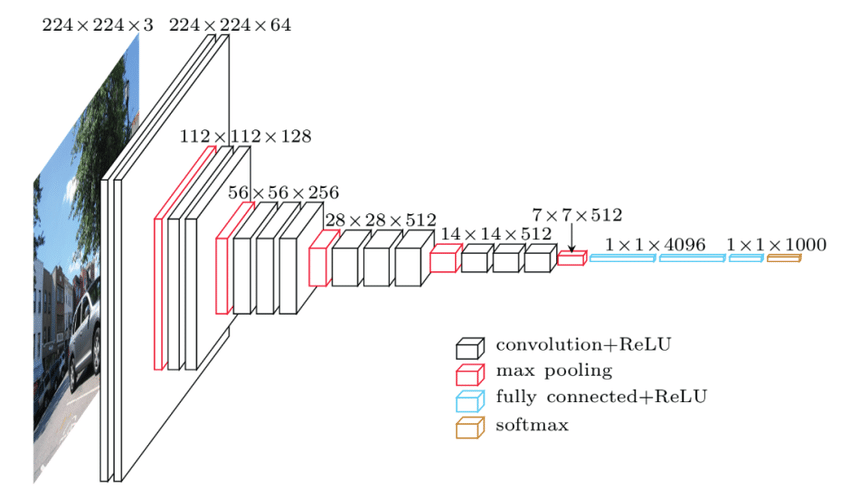

이전 CNN 구조보다 훨씬 더 많은 레이어를 사용하여 깊게 만든 신경망이다. 

깊이를 증가시켜 정확도를 높이면서도 filter 사이즈를 조정하여 파라미터 수가 크게 늘어나지 않도록 했다.

vgg의 block에 대해 코드를 짜보자!

In [21]:
def conv_2_block(in_features, out_features):
        net = nn.Sequential(
            nn.Conv2d(in_features, out_features, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(out_features, out_features, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        return net

In [22]:
def conv_3_block(in_features, out_features):
        net = nn.Sequential(
            nn.Conv2d(in_features, out_features, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(out_features, out_features, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(out_features, out_features, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        return net

In [ ]:
'''
Q4. 아래의 셀에 직접 conv block 갯수를 함수의 파라미터로 설정해서 넣을 수 있는 코드를 작성 (책의 코드 참고)
'''

In [26]:
def vgg_block(num_convs,in_channels,out_channels):
  layers = []
  for i in range(num_convs):
    layers.append(nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1))
    layers.append(nn.ReLU())
    in_channels = out_channels
  layers.append(nn.MaxPool2d(2, 2))
  return nn.Sequenital(*layers)

In [27]:
class VGGNet(nn.Module):
    def __init__(self, input_size = 227, num_classes=10):
        super(VGGNet, self).__init__()



        self.CNNLayer = nn.Sequential(
            conv_2_block(3, 64), # 3->64
            conv_2_block(64, 128), # 64->128
            conv_3_block(128, 256), # 128->256
            conv_3_block(256, 512), # 256->512
            conv_3_block(512, 512), # 512->512        
        )

        #self.avgpool = nn.AdaptiveAvgPool2d(7)

        self.FCLayer = nn.Sequential(
            nn.Linear(512*4*4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 1000),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1000, num_classes),
        )

    def forward(self, x):
        output = self.CNNLayer(x)
        #output = self.avgpool(output)
        output = output.view(-1, output.size(0))
        output = self.FCLayer(output)
        return output

In [28]:
vggnet = VGGNet(227, 10)
vggnet.to(device)

VGGNet(
  (CNNLayer): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, 

In [ ]:
import torchvision.models as models

vgg16 = models.vgg16(pretrained=True)
num_ftrs = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_ftrs, 10)

vgg16.to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
learning_rate = 0.0001 #가중치를 얼마나 크게 갱신할지 결정하는 학습률
training_epochs = 3 #반복학습의 횟수

In [ ]:
criterion = torch.nn.CrossEntropyLoss().to(device)   # loss function 정의
optimizer = torch.optim.SGD(vgg16.parameters(), lr=learning_rate, momentum = 0.9, weight_decay = 0.0005)   #optimizer 정의

In [ ]:
#모델 학습
training_model(model = vgg16, data_loader = data_loaders, epochs = training_epochs)

  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch:    1] train cost = 0.9630


  0%|          | 0/157 [00:00<?, ?it/s]

val Accuracy = {:.4f} 0.75


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch:    2] train cost = 0.4788


  0%|          | 0/157 [00:00<?, ?it/s]

val Accuracy = {:.4f} 0.9375


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch:    3] train cost = 0.3972


  0%|          | 0/157 [00:00<?, ?it/s]

val Accuracy = {:.4f} 0.875
total training time for 3 epochs: 98m 43s
Best val Accuracy: 0.9375


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## 3) GoogLeNet 구현 및 실제 데이터 적용하기

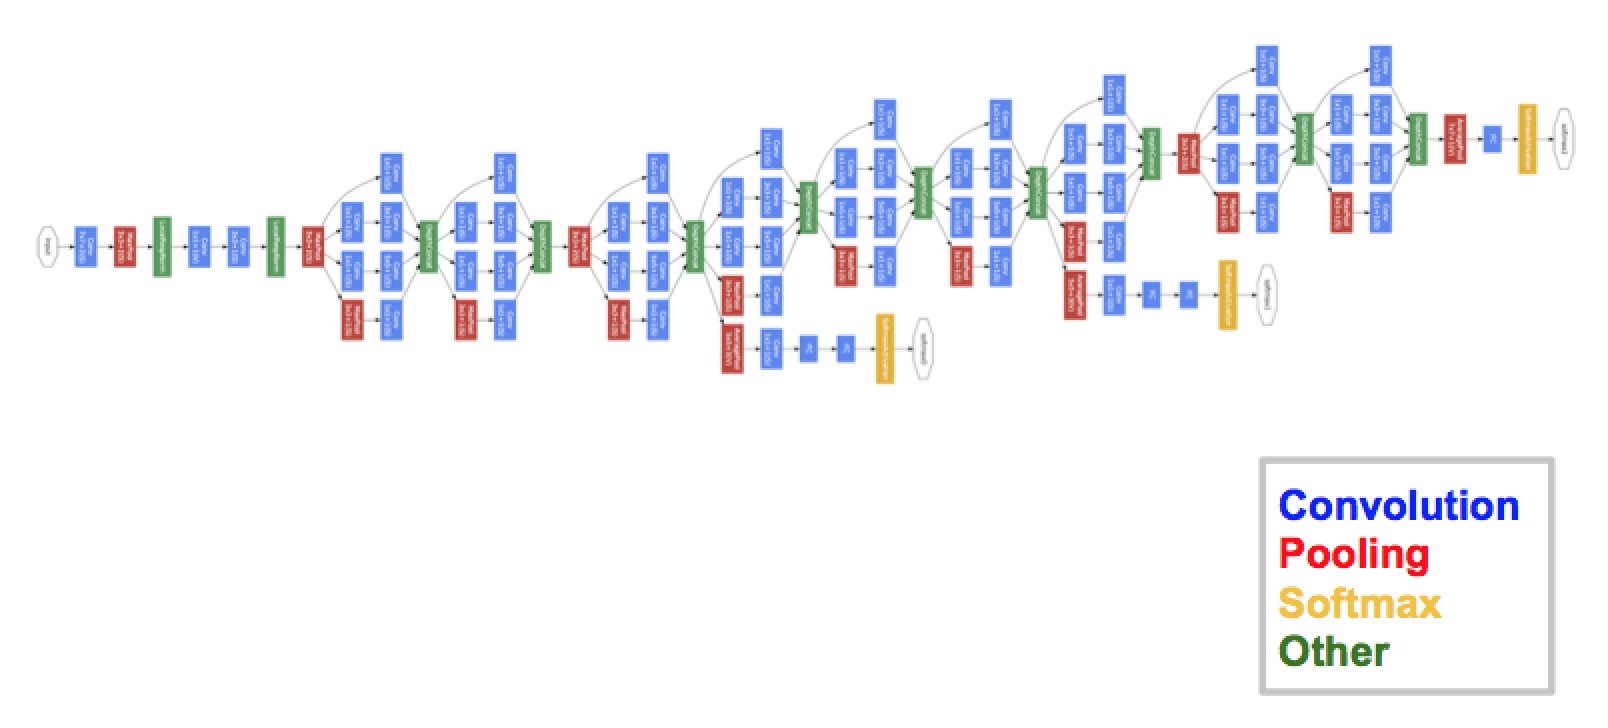

딥러닝 신경망이 깊어지면 그 구조가 sparse한 특징을 가지기 때문에 계산의 비효율성이 커진다. GoogLeNet은 이를 해결하기 위해 inception module이라는 것을 사용하여 신경망 내에 또다른 신경망을 넣은 것이다.

In [29]:
def conv_1(in_features,out_features):
    net = nn.Sequential(
        nn.Conv2d(in_features, out_features, 1, 1),
        nn.ReLU(),
    )
    return net

In [30]:
def conv_1_3(in_features, mid_features, out_features):
    net = nn.Sequential(
        nn.Conv2d(in_features, mid_features, 1, 1),
        nn.ReLU(),
        nn.Conv2d(mid_features, out_features, 3, 1, 1),
        nn.ReLU()
    )
    return net

In [31]:
def conv_1_5(in_features, mid_features, out_features):
    net = nn.Sequential(
        nn.Conv2d(in_features, mid_features, 1, 1),
        nn.ReLU(),
        nn.Conv2d(mid_features, out_features, 5, 1, 2),
        nn.ReLU()
    )
    return net

In [32]:
def max_3_1(in_features, out_features):
    net = nn.Sequential(
        nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 1),
        nn.Conv2d(in_features, out_features, 1, 1),
        nn.ReLU(),
    )
    return net

In [ ]:
'''
Q5. 아래의 빈칸(####)을 위에 정리된 path함수들로 채워넣기
'''

In [ ]:
class inception_module(nn.Module):
    def __init__(self, in_features, out_features_1, mid_features_3, out_features_3,
                 mid_features_5, out_features_5, pool_features):
        super(inception_module, self).__init__()

        # 1x1 -> 1x1
        self.p1_1 = conv_1(in_features, out_features_1)
        
        # 1x1 -> 3x3
        self.p1_2 = conv_1_3(in_features, mid_features_3, out_features_3)
        
        # 1x1 -> 5x5
        self.p1_3 = conv_1_5(in_features, mid_features_5, out_features_5)
        
        # 3x3 -> 1x1
        self.p1_4 = max_3_1(in_features, pool_features)

    def forward(self,x):
        output_1 = self.conv_1(x)
        output_2 = self.conv_1_3(x)
        output_3 = self.conv_1_5(x)
        output_4 = self.max_3_1(x)

        output = torch.cat([output_1, output_2, output_3, output_4], 1) # 모든  output 이어붙이기

        return output

In [ ]:
class GoogLeNet(nn.Module):
    def __init__(self, base_features, num_classes = 10):
        super(GoogLeNet, self).__init__()
        self.num_classes = num_classes

        self.layer_1 = nn.Sequential(
            nn.Conv2d(3, 64, 7, 2, 3),
            nn.MaxPool2d(3, 2, 1),
            nn.Conv2d(64, 192, 3, 1, 1),
            nn.MaxPool2d(3, 2, 1),
        )
        self.layer_2 = nn.Sequential(
            inception_module(192, 64, 96, 128, 16, 32, 32),
            inception_module(256, 128, 128, 192, 32, 96, 64),
            nn.MaxPool2d(3, 2, 1),
        )
        self.layer_3 = nn.Sequential(
            inception_module(480, 192, 96, 208, 16, 48, 64),
            inception_module(512, 160, 112, 224, 24, 64, 64),
            inception_module(512, 128, 128, 256, 24, 64, 64),
            inception_module(512, 112, 144, 288, 32, 64, 64),
            inception_module(528, 256, 160, 320, 32, 128, 128),
            nn.MaxPool2d(3, 2, 1),
        )
        self.layer_4 = nn.Sequential(
            inception_module(832, 256, 160, 320, 32, 128, 128),
            inception_module(832, 384, 192, 384, 48, 128, 128), 
            nn.AvgPool2d(7, 1),
        )
        self.layer_5 = nn.Dropout2d(0.4)

        self.FCLayer = nn.Linear(1024, self.num_classes)
                
        
    def forward(self, x):
        output = self.layer_1(x)
        output = self.layer_2(output)
        output = self.layer_3(output)
        output = self.layer_4(output)
        output = self.layer_5(output)
        output = output.view(batch_size, -1)
        output = self.FCLayer(output)
        return output

In [ ]:
googlenet = GoogLeNet(64, 10)
googlenet.to(device)

GoogLeNet(
  (layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer_2): Sequential(
    (0): inception_module(
      (conv_1): Sequential(
        (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
      )
      (conv_1_3): Sequential(
        (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
        (2): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
      (conv_1_5): Sequential(
        (0): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
        (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (3): ReLU()
      )
      (max_3_1): Sequential

In [ ]:
import torchvision.models as models

googlenet = models.googlenet(pretrained=True)
num_ftrs = googlenet.fc.in_features
googlenet.fc = nn.Linear(num_ftrs, 10)

googlenet.to(device)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
learning_rate = 0.0001 #가중치를 얼마나 크게 갱신할지 결정하는 학습률
training_epochs = 3 #반복학습의 횟수

In [ ]:
criterion = torch.nn.CrossEntropyLoss().to(device)   # loss function 정의
optimizer = torch.optim.SGD(googlenet.parameters(), lr=learning_rate, momentum = 0.9, weight_decay = 0.0005)   #optimizer 정의

In [ ]:
#모델 학습
training_model(model = googlenet, data_loader = data_loaders, epochs = training_epochs)

  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch:    1] train cost = 1.9496


  0%|          | 0/157 [00:00<?, ?it/s]

val Accuracy = {:.4f} 0.6875


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch:    2] train cost = 1.2049


  0%|          | 0/157 [00:00<?, ?it/s]

val Accuracy = {:.4f} 0.875


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch:    3] train cost = 0.8043


  0%|          | 0/157 [00:00<?, ?it/s]

val Accuracy = {:.4f} 0.75
total training time for 3 epochs: 28m 33s
Best val Accuracy: 0.8750


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

## 4) ResNet 구현 및 실제 데이터 적용하기

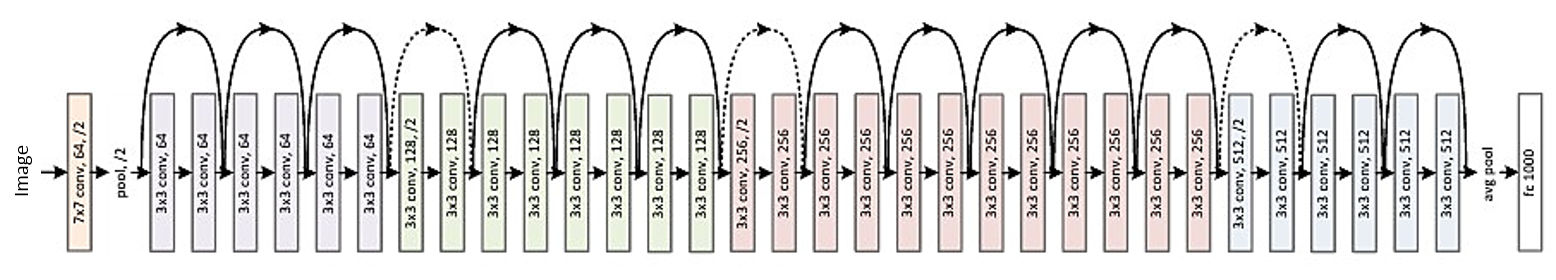

깊은 딥러닝 신경망에서 발생하는 기울기 소실/폭발 문제를 해결하기 위해 residual block을 사용하는 신경망이다. 

In [ ]:
def conv_block_1(in_features, out_features, stride=1):
    net = nn.Sequential(
        nn.Conv2d(in_features, out_features, kernel_size=1, stride = stride), 
        nn.BatchNorm2d(out_features), 
        nn.ReLU(),
    )
    return net

In [ ]:
def conv_block_3(in_features, out_features, stride=1):
    net = nn.Sequential(
        nn.Conv2d(in_features, out_features, kernel_size = 3, stride = stride, padding = 1), 
        nn.BatchNorm2d(out_features), 
        nn.ReLU(),
    )
    return net

In [ ]:
class BottleNeck(nn.Module):
    def __init__(self, in_features, mid_features, out_features, down=False):
        super(BottleNeck, self).__init__()
        self.down=down
        
        # feature map 크기가 감소하는 경우
        if self.down:
            self.layer = nn.Sequential(
              conv_block_1(in_features, mid_features, stride=2), 
              conv_block_3(mid_features, mid_features, stride=1), 
              conv_block_1(mid_features, out_features, stride=1), 
            )
            self.downsample = nn.Conv2d(in_features, out_features, kernel_size=1, stride=2)
            
        # feature map의 크기가 유지되는 경우
        else:
            self.layer = nn.Sequential(
                conv_block_1(in_features, mid_features, stride=1), 
                conv_block_3(mid_features, mid_features, stride=1), 
                conv_block_1(mid_features, out_features, stride=1), 
            )

        self.dim_equalizer = nn.Conv2d(in_features, out_features, kernel_size=1)
                  
    def forward(self, x):
        if self.down:
            downsample = self.downsample(x)
            output = self.layer(x)
            output = output + downsample
        else:
            output = self.layer(x)
            if x.size() is not output.size():
                x = self.dim_equalizer(x)
            output = output + x
        return output

In [ ]:
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
'''
Q6. 빈칸 채워넣기
'''
        self.layer_1 = nn.Sequential(
            nn.Conv2d(3,64,kernel_size = 7,stride = 2, paddding = 3),
            nn.ReLU(),
            nn.MaxPool2d(3,2,1),
        )
        self.layer_2 = nn.Sequential(
            BottleNeck(64,64,256),
            BottleNeck(256,64,256),
            BottleNeck(256,64,256,down=True),
        )   
        self.layer_3 = nn.Sequential(
            BottleNeck(256,128,512),
            BottleNeck(512,128,512),
            BottleNeck(512,128,512),
            BottleNeck(512,128,512,down=True),
        )
        self.layer_4 = nn.Sequential(
            BottleNeck(512,256,1024),
            BottleNeck(1024, 256, 1024),
            BottleNeck(1024, 256, 1024),            
            BottleNeck(1024, 256, 1024),
            BottleNeck(1024, 256, 1024),
            BottleNeck(1024, 256, 1024,down=True),
        )
        self.layer_5 = nn.Sequential(
            BottleNeck(1024,512,2048),
            BottleNeck(2048,512,2048),
            BottleNeck(2048,512,2048),
        )
        self.avgpool = nn.AvgPool2d(1,1) 
        self.fc_layer = nn.Linear(2048,num_classes)
        
    def forward(self, x):
        output = self.layer_1(x)
        output = self.layer_2(output)
        output = self.layer_3(output)
        output = self.layer_4(output)
        output = self.layer_5(output)
        output = self.avgpool(output)
        output = output.view(batch_size,-1)
        output = self.fc_layer(output)
        
        return output

In [ ]:
resnet = ResNet(10)
resnet.to(device)

ResNet(
  (layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer_2): Sequential(
    (0): BottleNeck(
      (layer): Sequential(
        (0): Sequential(
          (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (1): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (2): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
      )
      (dim_equalizer): Conv2d(64, 256, 

In [ ]:
import torchvision.models as models

resnet = models.resnet50(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 10)

resnet.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
learning_rate = 0.0001 #가중치를 얼마나 크게 갱신할지 결정하는 학습률
training_epochs = 3 #반복학습의 횟수

In [ ]:
criterion = torch.nn.CrossEntropyLoss().to(device)   # loss function 정의
optimizer = torch.optim.SGD(resnet.parameters(), lr=learning_rate, momentum = 0.9, weight_decay = 0.0005)   #optimizer 정의

In [ ]:
#모델 학습
training_model(model = resnet, data_loader = data_loaders, epochs = training_epochs)

  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch:    1] train cost = 1.5065


  0%|          | 0/157 [00:00<?, ?it/s]

val Accuracy = {:.4f} 0.75


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch:    2] train cost = 0.5789


  0%|          | 0/157 [00:00<?, ?it/s]

val Accuracy = {:.4f} 0.875


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch:    3] train cost = 0.3594


  0%|          | 0/157 [00:00<?, ?it/s]

val Accuracy = {:.4f} 0.8125
total training time for 3 epochs: 68m 31s
Best val Accuracy: 0.8750


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 